# TPC-DS Runner + Transplanted UDFs

## Setting up Spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TPC-DS Loader").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/11 22:17:41 WARN Utils: Your hostname, LAPTOP-7ECU52TP, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/11 22:17:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/11 22:17:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Setting Up Tables From Generated TPC-DS Data

We use sqlglot to read the DDL provided by TPC-DS and collect schema information. It is worth noting that sqlglot does not preserve information like primary/foreign key constraints or nullability of column values.

In [2]:
from sqlglot import parse_one, exp, parse
from pyspark.sql.types import (
	StructType, StructField, StringType, 
	DateType, TimestampType, IntegerType, 
	DecimalType
)

def to_spark_type(sql_type: str):
	if sql_type.startswith("CHAR"):
		return StringType()
	elif sql_type.startswith("VARCHAR"):
		return StringType()
	elif sql_type.startswith("INT"):
		return IntegerType()
	elif sql_type.startswith("DECIMAL"):
		return DecimalType(7, 2)
	elif sql_type.startswith("TIME"):
		return TimestampType()
	elif sql_type.startswith("DATE"):
		return DateType()
	else:
		return StringType()

ddl_path = "./tpcds-kit/tools/tpcds.sql"
with open(ddl_path) as f:
    sql = f.read()
    # trim leading comments
    sql = "\n".join([line for line in sql.split("\n") if not line.strip().startswith("--")])

schema = {}
for statement in parse(sql):
	if isinstance(statement, exp.Create):
		table_name = statement.this.this.this.this

		columns = []
		for col_def in statement.find_all(exp.ColumnDef):
			col_name = col_def.this.name
			col_type = col_def.args.get("kind").sql()
			spark_type = to_spark_type(col_type)
			columns.append(StructField(col_name, spark_type))

		schema[table_name] = StructType(columns)

all_column_types = set()
for table_cols in schema.values():
	for field in table_cols.fields:
		all_column_types.add(field.dataType)

print(len(schema))
print(all_column_types)

25
{TimestampType(), IntegerType(), StringType(), DecimalType(7,2), DateType()}


In [3]:
def create_table_from_data(table_name: str, data_path: str):
	df = spark.read \
		.option("delimiter", "|") \
		.option("timestampFormat", "HH:mm:ss") \
		.schema(schema[table_name]) \
		.csv(data_path)
	
	df.createOrReplaceTempView(table_name)



In [4]:
import glob
import os

data_dir = "./generated_data" # replace with your directory target used with dsdgen

for path in glob.glob(os.path.join(data_dir, "*.dat")):
	file_name = os.path.basename(path)
	table_name = file_name[:-4]

	create_table_from_data(table_name, path)

spark.sql("SHOW TABLES").count()

25/12/11 22:17:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


25

## Running Generated TPC-DS Queries

In [32]:
from pathlib import Path
import time

sql_dir = Path("./processed_queries") # replace with your dir containing split queries.

runnable = []
total_queries = 0
for sql_file in sorted(sql_dir.glob("*.sql")):
	with open(sql_file, "r") as f:
		query = f.read()
	
	total_queries += 1
	if query:
		try:
			start_time = time.time()
			df = spark.sql(query).count()
			runnable.append({
				"query": query,
				"elapsed_time_without_udfs": time.time() - start_time,
			})
		except Exception as e:
			print(f"Error executing query from {sql_file}")

print(f"Total queries processed: {total_queries}")
print(f"Total runnable queries: {len(runnable)}")

Error executing query from processed_queries/query_102.sql


Error executing query from processed_queries/query_15.sql


Error executing query from processed_queries/query_18.sql


Error executing query from processed_queries/query_25.sql
Error executing query from processed_queries/query_26.sql


Error executing query from processed_queries/query_32.sql
Error executing query from processed_queries/query_33.sql


25/12/12 02:01:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 0

Error executing query from processed_queries/query_44.sql
Error executing query from processed_queries/query_45.sql


25/12/12 02:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 02:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 0

Error executing query from processed_queries/query_61.sql


Error executing query from processed_queries/query_65.sql
Error executing query from processed_queries/query_66.sql


Error executing query from processed_queries/query_68.sql


Error executing query from processed_queries/query_7.sql


Error executing query from processed_queries/query_8.sql


Error executing query from processed_queries/query_81.sql


Error executing query from processed_queries/query_89.sql


Error executing query from processed_queries/query_98.sql


Total queries processed: 103
Total runnable queries: 85


## Transplanting UDFs

1. We provide `sqlglot` the table schemas and canonical query to produce the query tree with type annotations.
2. We then register some udfs
3. We transplant udf calls into the query tree and obtain the new canonical query
4. We attempt to run the updated canonical query

In [33]:
from sqlglot import parse_one, exp, parse
from sqlglot.schema import MappingSchema
from sqlglot.optimizer import optimize


with open("./tpcds-kit/tools/tpcds.sql") as f:
    sql = f.read()
    sql = "\n".join(
        [line for line in sql.split("\n") if not line.strip().startswith("--")]
    )

map_schema = {}
for statement in parse(sql):
    if isinstance(statement, exp.Create):
        table_name = statement.this.this.this.this

        columns = {}
        for col_def in statement.find_all(exp.ColumnDef):
            col_name = col_def.this.name
            col_type = col_def.args.get("kind").sql()
            columns[col_name] = col_type

        map_schema[table_name] = columns

schema_obj = MappingSchema(map_schema)
print(map_schema)


{'dbgen_version': {'dv_version': 'VARCHAR(16)', 'dv_create_date': 'DATE', 'dv_create_time': 'TIME', 'dv_cmdline_args': 'VARCHAR(200)'}, 'customer_address': {'ca_address_sk': 'INT', 'ca_address_id': 'CHAR(16)', 'ca_street_number': 'CHAR(10)', 'ca_street_name': 'VARCHAR(60)', 'ca_street_type': 'CHAR(15)', 'ca_suite_number': 'CHAR(10)', 'ca_city': 'VARCHAR(60)', 'ca_county': 'VARCHAR(30)', 'ca_state': 'CHAR(2)', 'ca_zip': 'CHAR(10)', 'ca_country': 'VARCHAR(20)', 'ca_gmt_offset': 'DECIMAL(5, 2)', 'ca_location_type': 'CHAR(20)'}, 'customer_demographics': {'cd_demo_sk': 'INT', 'cd_gender': 'CHAR(1)', 'cd_marital_status': 'CHAR(1)', 'cd_education_status': 'CHAR(20)', 'cd_purchase_estimate': 'INT', 'cd_credit_rating': 'CHAR(10)', 'cd_dep_count': 'INT', 'cd_dep_employed_count': 'INT', 'cd_dep_college_count': 'INT'}, 'date_dim': {'d_date_sk': 'INT', 'd_date_id': 'CHAR(16)', 'd_date': 'DATE', 'd_month_seq': 'INT', 'd_week_seq': 'INT', 'd_quarter_seq': 'INT', 'd_year': 'INT', 'd_dow': 'INT', 'd_mo

In [30]:
from pyspark.sql.functions import udf

@udf(StringType())
def dummy_string(x):
	return x

@udf(IntegerType())
def dummy_integer(x):
	return x

@udf(DecimalType(7, 2))
def dummy_decimal(x):
	return x

@udf(TimestampType())
def dummy_timestamp(x):
	return x

@udf(DateType())
def dummy_date(x):
	return x

spark.udf.register("DUMMY_STRING", dummy_string)
spark.udf.register("DUMMY_INTEGER", dummy_integer)
spark.udf.register("DUMMY_DECIMAL", dummy_decimal)
spark.udf.register("DUMMY_TIMESTAMP", dummy_timestamp)
spark.udf.register("DUMMY_DATE", dummy_date)

25/12/12 01:56:21 WARN SimpleFunctionRegistry: The function dummy_string replaced a previously registered function.
25/12/12 01:56:21 WARN SimpleFunctionRegistry: The function dummy_integer replaced a previously registered function.
25/12/12 01:56:21 WARN SimpleFunctionRegistry: The function dummy_decimal replaced a previously registered function.
25/12/12 01:56:21 WARN SimpleFunctionRegistry: The function dummy_timestamp replaced a previously registered function.
25/12/12 01:56:21 WARN SimpleFunctionRegistry: The function dummy_date replaced a previously registered function.


In [34]:
import numpy as np

def get_dummy_udf(type: str):
	sqlglot_type = type.upper()

	if sqlglot_type.startswith("CHAR"):
		return "dummy_string"
	elif sqlglot_type.startswith("VARCHAR"):
		return "dummy_string"
	elif sqlglot_type.startswith("INT"):
		return "dummy_integer"
	elif sqlglot_type.startswith("DECIMAL"):
		return "dummy_decimal"
	elif sqlglot_type.startswith("TIME"):
		return "dummy_timestamp"
	elif sqlglot_type.startswith("DATE"):
		return "dummy_date"
	else:
		return ""


successful_queries = 0
for q in runnable:
	query = q["query"]

	parsed = parse_one(query)
	optimized = optimize(parsed, schema=schema_obj)

	if isinstance(optimized, exp.CTE):
		main_query = optimized.this
	else:
		main_query = optimized

	for select in main_query.find_all(exp.Select):
		new_expressions = []

		for expr in select.expressions:
			if isinstance(expr, exp.Alias) and isinstance(expr.this, exp.Column):
				alias_name = expr.alias
				column_name = expr.this.name
				column_type = expr.this._type.sql()

				dummy_udf = get_dummy_udf(column_type)
				if dummy_udf:
					udf_node = exp.Anonymous(this=dummy_udf, expressions=[expr.this.copy()])
					alias_node = exp.Alias(this=udf_node, alias=alias_name)
					new_expressions.append(alias_node)
				else:
					new_expressions.append(expr)
			else:
				new_expressions.append(expr)

		select.set("expressions", new_expressions)
	
	# new_query = optimized.sql(pretty=True)
	try:
		new_query = optimized.sql(pretty=True).replace('\"', '')
		start = time.time()
		df = spark.sql(new_query).count()
		q["elpased_time_with_udfs"] = time.time() - start
		successful_queries += 1
	except Exception as e:
		q["elpased_time_with_udfs"] = np.nan

print(f"UDF transplant success rate: {successful_queries} / {len(runnable)}")
	

25/12/12 02:14:14 ERROR Executor: Exception in task 8.0 in stage 1633.0 (TID 6328)
org.apache.spark.SparkArithmeticException: [NUMERIC_VALUE_OUT_OF_RANGE.WITHOUT_SUGGESTION]  The 952539.50 rounded half up from 952539.50 cannot be represented as Decimal(7, 2). SQLSTATE: 22003
	at org.apache.spark.sql.types.Decimal.set(Decimal.scala:130)
	at org.apache.spark.sql.types.Decimal$.apply(Decimal.scala:608)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$8$1.applyOrElse(EvaluatePython.scala:134)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:221)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$8(EvaluatePython.scala:133)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$16$1.applyOrElse(EvaluatePython.scala:196)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:221)
	at org.apac

[7388.140s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 2472.0 (TID 9479): Retried waiting for GCLocker too often allocating 524290 words
[7388.140s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 2472.0 (TID 9477): Retried waiting for GCLocker too often allocating 524290 words
[7388.294s][warning][gc,alloc] Executor task launch worker for task 14.0 in stage 2472.0 (TID 9491): Retried waiting for GCLocker too often allocating 1048578 words
[7388.333s][warning][gc,alloc] Executor task launch worker for task 9.0 in stage 2472.0 (TID 9486): Retried waiting for GCLocker too often allocating 1048578 words


25/12/12 02:22:10 WARN TaskMemoryManager: Failed to allocate a page (4194304 bytes), try again.
25/12/12 02:22:10 WARN TaskMemoryManager: Failed to allocate a page (4194304 bytes), try again.
25/12/12 02:22:10 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
25/12/12 02:22:10 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.


UDF transplant success rate: 83 / 85


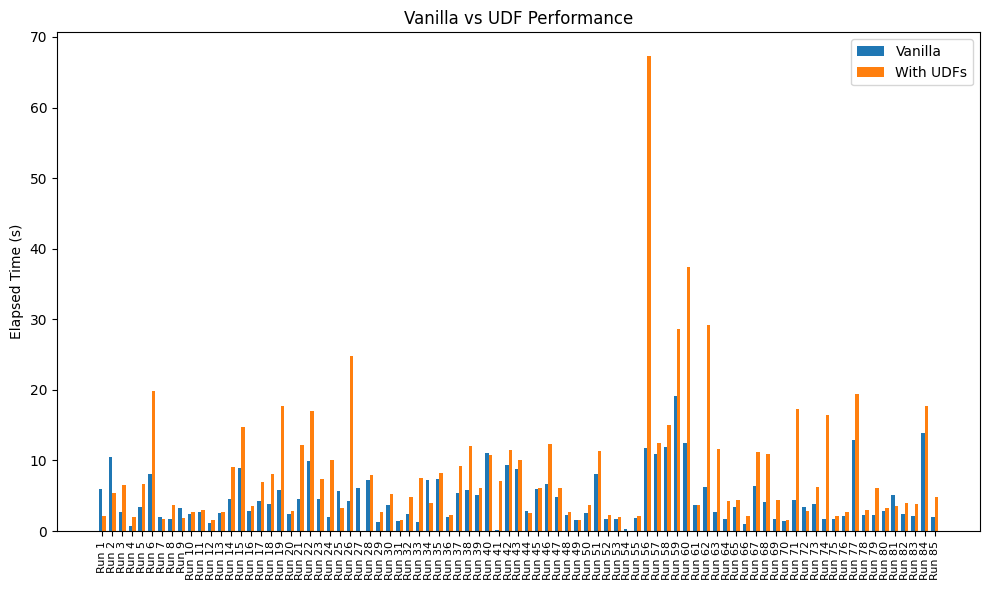

In [36]:
import matplotlib.pyplot as plt

vanilla_times = [r["elapsed_time_without_udfs"] for r in runnable]
udf_times = [r["elpased_time_with_udfs"] for r in runnable]

x = np.arange(len(vanilla_times))  # x-axis positions
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, vanilla_times, width, label='Vanilla')
ax.bar(x + width/2, udf_times, width, label='With UDFs')

ax.set_xticks(x)
ax.set_xticklabels([f"Run {i+1}" for i in x], rotation=90, fontsize=8)

ax.set_ylabel("Elapsed Time (s)")
ax.set_title("Vanilla vs UDF Performance")
ax.legend()

plt.tight_layout()
plt.show()

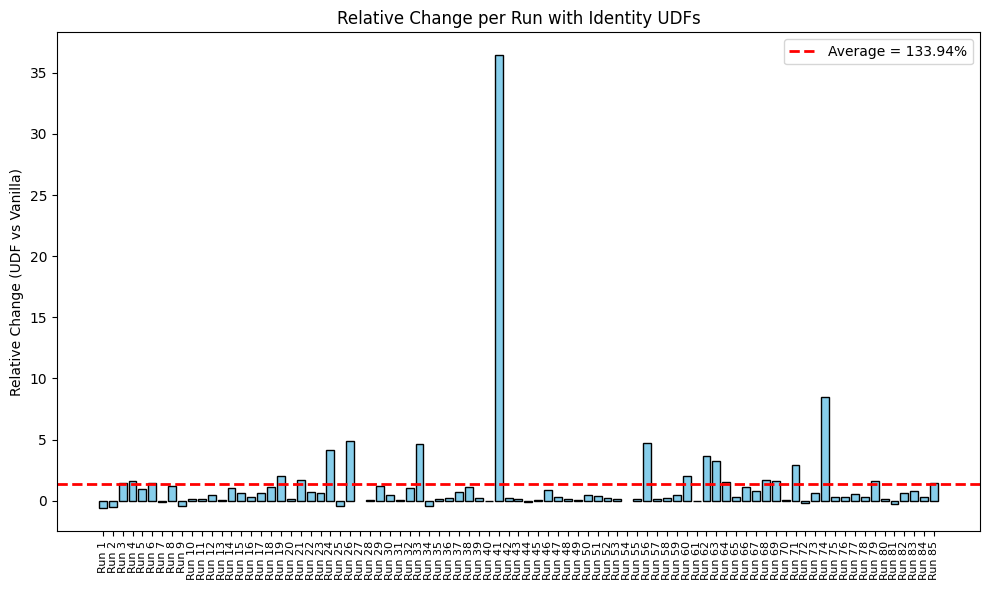

In [38]:
relative_change = [(u - v)/v for u, v in zip(udf_times, vanilla_times)]

avg_change = np.nanmean(relative_change)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(x, relative_change, color='skyblue', edgecolor='black')
ax.axhline(avg_change, color='red', linestyle='--', linewidth=2, label=f'Average = {avg_change:.2%}')

ax.set_xticks(x)
ax.set_xticklabels([f"Run {i+1}" for i in x], rotation=90, fontsize=8)

ax.set_ylabel("Relative Change (UDF vs Vanilla)")
ax.set_title("Relative Change per Run with Identity UDFs")
ax.legend()

plt.tight_layout()
plt.show()